Гибель Титаника – одно из самых печально известных кораблекрушений в истории.

15 апреля 1912 года во время своего первого плавания считавшийся «непотопляемым» «Титаник» затонул после столкновения с айсбергом. К сожалению, спасательных шлюпок для всех на борту не хватило, в результате чего погибли 1502 из 2224 пассажиров и экипажа.

Хотя в выживании присутствовал некоторый элемент удачи, похоже, что у некоторых групп людей было больше шансов выжить, чем у других.

В этом задании мы просим вас построить прогнозирующую модель, которая ответит на вопрос: «Какие люди имеют больше шансов выжить?» с использованием данных о пассажирах (т. е. имени, возраста, пола, социально-экономического класса и т. д.).  

Показателем качества предсказаний здесь является вероятность правильного предсказания от 0 до 1.

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Data Preparation

In [4]:
target_words = ['Mr', 'Mrs', 'Miss']
def create_features(df):
    # Признак одиночества. Если пассажир путешествовал один, то ему легче было спастись
    df['Alone_status'] = df['Parch'].apply(lambda x: 'yes' if x == 0 else 'no')
    # Длина имени пассажира. Которая может указывать на его статусность, а значит большую вероятность спастись.
    df['len_name'] = df['Name'].apply(len)
    # группа возраста. Молодые старые пожилые.
    df['Age_group'] = df['Age'].apply(lambda x: 'young' if x < 18 else('middle' if x < 50 else 'old'))
    # Наличие титула Mr, Mrs, Miss
    df['Title'] = df['Name'].apply(lambda x: 'yes' if any(word in x for word in target_words) else 'no') 
    return df

In [5]:
train = create_features(train)

In [6]:
test = create_features(test)

In [7]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Alone_status',
       'len_name', 'Age_group', 'Title'],
      dtype='object')

In [8]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Alone_status', 'len_name',
       'Age_group', 'Title'],
      dtype='object')

# Data Analyse

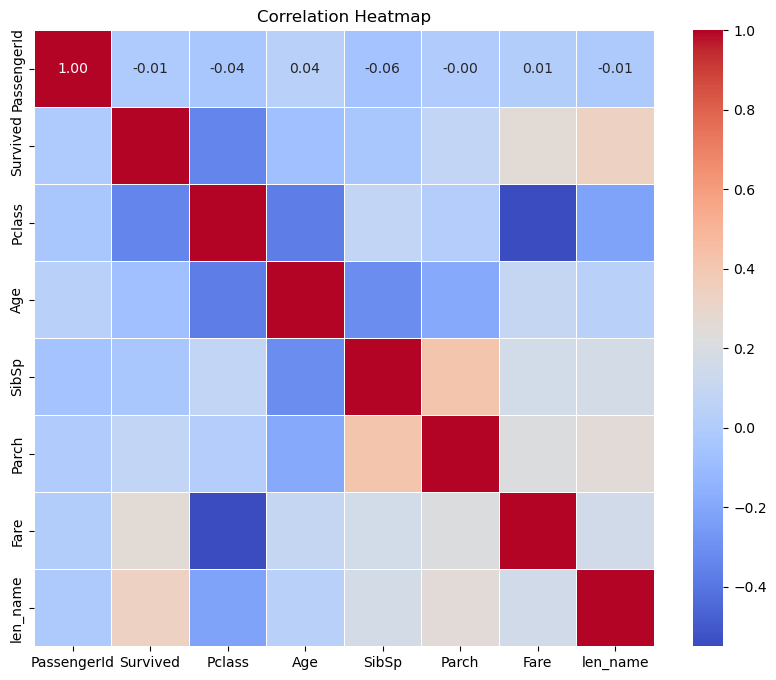

In [9]:
correlation_matrix = train.select_dtypes(include=['float64', 'int']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
 12  Alone_status  891 non-null    object 
 13  len_name      891 non-null    int64  
 14  Age_group     891 non-null    object 
 15  Title         891 non-null    object 
dtypes: float64(2), int64(6), object(8)
memory usage: 111.5+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   418 non-null    int64  
 1   Pclass        418 non-null    int64  
 2   Name          418 non-null    object 
 3   Sex           418 non-null    object 
 4   Age           332 non-null    float64
 5   SibSp         418 non-null    int64  
 6   Parch         418 non-null    int64  
 7   Ticket        418 non-null    object 
 8   Fare          417 non-null    float64
 9   Cabin         91 non-null     object 
 10  Embarked      418 non-null    object 
 11  Alone_status  418 non-null    object 
 12  len_name      418 non-null    int64  
 13  Age_group     418 non-null    object 
 14  Title         418 non-null    object 
dtypes: float64(2), int64(5), object(8)
memory usage: 49.1+ KB


# Data Cleaning

In [12]:
def cleaning_df(df):
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode().values[0], inplace=True)
    df.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)
    return df

In [13]:
train = cleaning_df(train)
test = cleaning_df(test)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Sex           891 non-null    object 
 4   Age           891 non-null    float64
 5   SibSp         891 non-null    int64  
 6   Parch         891 non-null    int64  
 7   Fare          891 non-null    float64
 8   Embarked      891 non-null    object 
 9   Alone_status  891 non-null    object 
 10  len_name      891 non-null    int64  
 11  Age_group     891 non-null    object 
 12  Title         891 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   418 non-null    int64  
 1   Pclass        418 non-null    int64  
 2   Sex           418 non-null    object 
 3   Age           418 non-null    float64
 4   SibSp         418 non-null    int64  
 5   Parch         418 non-null    int64  
 6   Fare          417 non-null    float64
 7   Embarked      418 non-null    object 
 8   Alone_status  418 non-null    object 
 9   len_name      418 non-null    int64  
 10  Age_group     418 non-null    object 
 11  Title         418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


<Axes: >

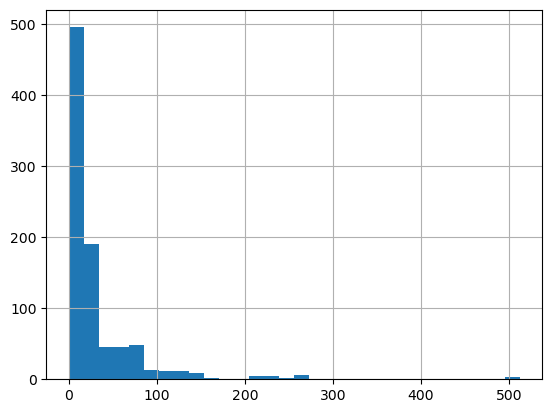

In [16]:
train['Fare'].hist(bins=30)

In [17]:
def clean_lg(df): 
    try:
        df_copy = df.copy()
        df_copy = df_copy.drop(columns=['Sex', 'Embarked', 'Alone_status', 'Age_group', 'Title'], axis=1)
        df_missing = df_copy[df_copy['Fare'].isnull()]
        df_not_missing = df_copy[~df_copy['Fare'].isnull()]

        X = df_not_missing.drop(['Fare'], axis=1)
        y = df_not_missing['Fare']

        model = RandomForestRegressor(n_estimators=100)
        model.fit(X, y)
        missing_values = model.predict(df_missing.drop(['Fare'], axis=1))

        df_copy.loc[df_copy['Fare'].isnull(), 'Fare'] = missing_values
        df['Fare'] = df_copy['Fare']

        return df
    
    except:
        return df
    

In [18]:
train = clean_lg(train)
test = clean_lg(test)

In [19]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Alone_status,len_name,Age_group,Title
0,1,0,3,male,22.0,1,0,7.2500,S,yes,23,middle,yes
1,2,1,1,female,38.0,1,0,71.2833,C,yes,51,middle,yes
2,3,1,3,female,26.0,0,0,7.9250,S,yes,22,middle,yes
3,4,1,1,female,35.0,1,0,53.1000,S,yes,44,middle,yes
4,5,0,3,male,35.0,0,0,8.0500,S,yes,24,middle,yes


# Feature Engineering

In [20]:
print(train.isnull().sum())

PassengerId     0
Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Alone_status    0
len_name        0
Age_group       0
Title           0
dtype: int64


In [21]:
print(test.isnull().sum())

PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Alone_status    0
len_name        0
Age_group       0
Title           0
dtype: int64


In [22]:
# Кодировка категориальных признаков и удаление колонок, не нужных для модели прогнозирования.
def feature_eng(df):
    categorical_features = ['Sex', 'Alone_status', 'Embarked', 'Age_group', 'Title']
    ohe = OneHotEncoder(sparse=False)
    encoded_features = ohe.fit_transform(df[categorical_features])
    df_encoded = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_features))
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, df_encoded], axis=1)
    df.drop(columns=categorical_features, inplace=True)
    
    # Нормализация числовых признаков    
    scaler = StandardScaler()
    numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'len_name']
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    return df

In [23]:
train = feature_eng(train)
test = feature_eng(test)

In [24]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,len_name,Sex_female,Sex_male,Alone_status_no,Alone_status_yes,Embarked_C,Embarked_Q,Embarked_S,Age_group_middle,Age_group_old,Age_group_young,Title_no,Title_yes
0,1,0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,-0.427451,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,2,1,-1.566107,0.663861,0.432793,-0.473674,0.786845,2.590962,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,3,1,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,-0.535252,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,4,1,-1.566107,0.433312,0.432793,-0.473674,0.420730,1.836359,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,5,0,0.827377,0.433312,-0.474545,-0.473674,-0.486337,-0.319651,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


# Feature Evaluation

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Survived          891 non-null    int64  
 2   Pclass            891 non-null    float64
 3   Age               891 non-null    float64
 4   SibSp             891 non-null    float64
 5   Parch             891 non-null    float64
 6   Fare              891 non-null    float64
 7   len_name          891 non-null    float64
 8   Sex_female        891 non-null    float64
 9   Sex_male          891 non-null    float64
 10  Alone_status_no   891 non-null    float64
 11  Alone_status_yes  891 non-null    float64
 12  Embarked_C        891 non-null    float64
 13  Embarked_Q        891 non-null    float64
 14  Embarked_S        891 non-null    float64
 15  Age_group_middle  891 non-null    float64
 16  Age_group_old     891 non-null    float64
 1

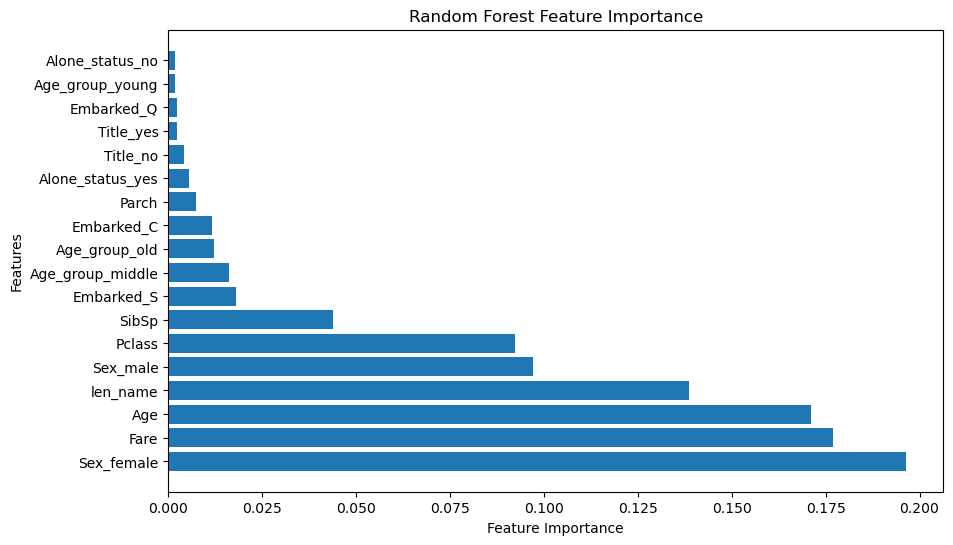

In [26]:
# Загрузка данных
X = train.drop(columns=['PassengerId', 'Survived'], axis=1)
y = train['Survived']

# Создаем модель случайного леса
model = RandomForestRegressor(n_estimators=10, random_state=42)

# Обучаем модель
model.fit(X, y)

# Получаем важность признаков
feature_importance = model.feature_importances_

# Создаем DataFrame, чтобы удобно отобразить результаты
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Сортируем признаки по важности в убывающем порядке
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Визуализируем важность признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

# Data Spliting

In [27]:
# Разделение данных на обучающий и тестовый наборы
X = train.drop(columns=['Survived', 'PassengerId'])
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection

In [28]:
models = []
models.append(('log_regress', LogisticRegression(penalty='l2', C=1)))
models.append(('dt_classifier', DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)))
models.append(('rf_classif', RandomForestClassifier(max_depth=6, max_features=6)))
models.append(('mlp', MLPClassifier(hidden_layer_sizes=(100, 30), max_iter=1000, random_state=42)))

results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    mean_accuracy = cv_results.mean()
    print(f'{name}, средняя точность: {mean_accuracy:.4f}')

log_regress, средняя точность: 0.8132
dt_classifier, средняя точность: 0.8315
rf_classif, средняя точность: 0.8301
mlp, средняя точность: 0.7865


In [29]:
model = models[2][1]
model.fit(X, y)

RandomForestClassifier(max_depth=6, max_features=6)

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Pclass            891 non-null    float64
 1   Age               891 non-null    float64
 2   SibSp             891 non-null    float64
 3   Parch             891 non-null    float64
 4   Fare              891 non-null    float64
 5   len_name          891 non-null    float64
 6   Sex_female        891 non-null    float64
 7   Sex_male          891 non-null    float64
 8   Alone_status_no   891 non-null    float64
 9   Alone_status_yes  891 non-null    float64
 10  Embarked_C        891 non-null    float64
 11  Embarked_Q        891 non-null    float64
 12  Embarked_S        891 non-null    float64
 13  Age_group_middle  891 non-null    float64
 14  Age_group_old     891 non-null    float64
 15  Age_group_young   891 non-null    float64
 16  Title_no          891 non-null    float64
 1

In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       418 non-null    int64  
 1   Pclass            418 non-null    float64
 2   Age               418 non-null    float64
 3   SibSp             418 non-null    float64
 4   Parch             418 non-null    float64
 5   Fare              418 non-null    float64
 6   len_name          418 non-null    float64
 7   Sex_female        418 non-null    float64
 8   Sex_male          418 non-null    float64
 9   Alone_status_no   418 non-null    float64
 10  Alone_status_yes  418 non-null    float64
 11  Embarked_C        418 non-null    float64
 12  Embarked_Q        418 non-null    float64
 13  Embarked_S        418 non-null    float64
 14  Age_group_middle  418 non-null    float64
 15  Age_group_old     418 non-null    float64
 16  Age_group_young   418 non-null    float64
 1

In [32]:
predictions_rf = model.predict(test.drop(columns='PassengerId'))
test['Survived'] = predictions_rf

In [33]:
df_final = test[['PassengerId', 'Survived']]
df_final['Survived'].value_counts()

Survived
0    270
1    148
Name: count, dtype: int64

In [34]:
df_final.to_csv('df_final_26-10.csv', index=False)

In [35]:
model = models[1][1]
model.fit(X, y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)

<img src = 'leaderboard.png' />